# CIC Current System Network Graph

# Graph overview 

Modeling as a weighted directed graph with agents as nodes. A network is a set of items (nodes or vertices) connected by edges or links. 
We represent a network by a graph (N, g), which consists of a set of nodes N = {1, . . . , n}.

#### Node types
* Agent

An agent is a user of the CIC system.
* Chama

A chama is a savings group consisting of multiple agents. Redemptions of CICs for fiat occur through chamas.
* Trader

A trader is an agent interacting with the bonding curve for investment/arbitrage opportunities.
* Cloud

The cloud is a representation of the open boundary to the world external to the model.
* Contract

The contract is the smart contract of the bonding curve.

### Edges between agents
The edge weight gij > 0 takes on non-binary values, representing the intensity of the interaction, so we refer to (N, g) as a weighted graph.
E is the set of “directed” edges, i.e., (i, j) ∈ E

#### Edge types
* Demand
* Fraction of demand in CIC
* Utility - stack ranking. Food/Water is first, shopping, etc farther down
* Spend
* Fraction of actual in CIC

![](images/dualoperator.png)


![](images/v3differentialspec.png)

## Assumptions
(Defining data structures, not just initialization. Baking in degrees of freedom for future experimentation)

* agents = a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p
* Agent starting native currency is picked from a uniform distribution with a range of 20 to 500. Starting tokens is 400.
* system = external,cic
* chama = chama_1,chama_2,chama_3,chama_4

Chamas are currently set to zero, it can be configured for more detailed analysis later on.
* traders = ta,tb,tc

Traders are currently set to zero, it can be configured for more detailed analysis later on.
* Utility Types Ordered:
 * Food/Water
 * Fuel/Energy
 * Health
 * Education
 * Savings Group
 * Shop
* Utility Types Probability 
  * 0.6
  * 0.10
  * 0.03
  * 0.015
  * 0.065
  * 0.19
* R0 = 500
* S0 = 200000
* P = 1
* priceLevel = 100
* fractionOfDemandInCIC = 0.5
* fractionOfActualSpendInCIC = 0.5 # if an agent is interacting with the external environment, then the actual spend is 100% shilling.
* kappa = 4


## Initial State Values

# Equations

## Generators
* Agent generation for each time step: Random choice of all agents minus 2 for both paying and receiving.  

* Agent demand each time: Uniform distribution with a low value of 1 and a high of 500. 
 
### Red Cross Drip
Every 30 days, the Red Cross drips 4000 shilling to the grassroots operator fiat balance.  

### Spend Allocation 

#### Parameters:
* Agent to pay: $i$
* Agent to receive: $j$
* Rank Order Demand: $\frac{v_{i,j}}{d_{i,j}}$
* Amount of currency agent $i$ has to spend, $\gamma$
* Amount of cic agent $i$ has to spend, $\gamma_\textrm{cic}$
* Percentage of transaction in cic, $\phi$
* Spend, $\zeta$


if $\frac{v_{i,j}}{d_{i,j}} * 1-\phi > \gamma_{i} \textrm{and} \frac{v_{i,j}}{d_{i,j}} * \phi > \gamma_\textrm{cic} \Rightarrow \zeta = \frac{v_{i,j}}{d_{i,j}}$ 

else $ \Rightarrow \zeta = \gamma$

Allocate utility type by stack ranking in. Allocate remaining fiat and cic until all demand is met or i runs out.


### Withdraw calculation

The user is able to withdraw up to 50% of the their CIC balance if they have spent 50% of their balance within the last 30 days at a conversion ratio of 1:1, meaning that for every one token withdraw, they receive 1 in native currency. We are assuming that agents want what to withdraw as much as they can.
This is one of the most important control points for Grassroots economics. The more people withdraw CIC from the system, the more difficult it is on the system. The more people can withdraw, the better the adoption however. The inverse also holds true: the less individuals can withdraw, the lower the adoption.

## Distribution to agents
#### Parameters
FrequencyOfAllocation = 45 # frequency of allocation of drip to agents
* idealFiat = 5000
* idealCIC = 200000
* varianceCIC = 50000
* varianceFiat = 1000
* unadjustedPerAgent = 50

```
# agent:[centrality,allocationValue]
agentAllocation = {'a':[1,1],'b':[1,1],'c':[1,1], 
                   'd':[1,1],'e':[1,1],'f':[1,1],
                   'g':[1,1],'h':[1,1],'i':[1,1],
                   'j':[1,1],'k':[1,1],'l':[1,1],
                   'm':[1,1],'o':[1,1],'p':[1,1]}
```

Every 15 days, a total of unadjustedPerAgent * agents will be distributed among the agents. Allocation will occur based off of the the agent allocation dictionary allocation value. We can optimize the allocation overtime and make a state variable for adjustment overtime as a result of centrality. We are currently assuming that all agents have the same centrality and allocation.

Internal velocity is better than external velocity of the system. Point of leverage to make more internal cycles. Canbe used for tuning system effiency.
![](images/agentDistribution.png)

### Inventory Controller
Heuristic Monetary policy hysteresis conservation allocation between fiat and cic reserves. We've created an inventory control function to test if the current balance is in an acceptable tolarance. For the calculation, we use the following 2 variables, current CIC balance and current fiat balance, along with 2 parameters, desired cic and variance.

Below is 
```
if idealCIC - variance <= actual <= ideal + (2*variance):
    decision = 'none'
    amount = 0
else:
    
    if (ideal + variance) > actual :
        decision = 'mint'
        amount = (ideal + variance) - actual
    else:
        pass
    if actual > (ideal + variance):
        decision = 'burn'
        amount = actual - (ideal + variance) 
    else:
        pass

if decision == 'mint':
    if fiat < (ideal - variance):
        if amount > fiat:
            decision = 'none'
            amount = 0
        else:
            pass
if decision == 'none':
    if fiat < (ideal - variance):
        decision = 'mint'
        amount = (ideal-variance)
    else:
        pass
    

```

If the controller wants to mint, the amount decided from the inventory controller, $\Delta R$ is inserted into the following minting equation:

- Conservation equation, V0: $V(R+ \Delta R', S+\Delta S) = \frac{(S+\Delta S)^\kappa}{R+\Delta R'} =\frac{S^\kappa}{R}$
- Derived Mint equation: $\Delta S = mint\big(\Delta R ; (R,S)\big)= S\big(\sqrt[\kappa]{(1+\frac{\Delta R}{R})}-1\big)$
 


If the controller wants to burn, the amount decided from the inventory controller, $\Delta S$ is inserted into the following minting equation:
 - Derived Withdraw equation: $\Delta R = withdraw\big(\Delta S ; (R,S)\big)= R\big(1-(1-\frac{\Delta S}{S})^\kappa \big)$
 

There is a built in process lag of 7 days before the newly minted or burned CIC is added to the respective operator accounts.

### Velocity of Money 

Indirect measurement of velocity of money per timestep:

$V_t = \frac{PT}{M}$

Where

* $V_t$ is the velocity of money for all agent transaction in the time period examined
* $P$ is the price level
* $T$ is the aggregated real value of all agent transactions in the time period examined
* $M$ is the average money supply in the economy in the time period examined.



## Simulation run
* 5 monte carlo runs with 100 timesteps. Each timestep is equal to 1 day.


## Proposed Experiments
![](images/experiments.png)

# Define cadCAD Model

In [1]:
!pip install cadCAD

In [2]:
# import libraries
import math
from decimal import Decimal
from datetime import timedelta
import numpy as np
from typing import Dict, List

from cadCAD.configuration import append_configs
from cadCAD.configuration.utils import bound_norm_random, ep_time_step, config_sim, access_block


# The following imports NEED to be in the exact order
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from cadCAD import configs


import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import clear_output
import networkx as nx
from collections import OrderedDict
pd.options.display.float_format = '{:.2f}'.format

%matplotlib inline

In [3]:
# Supporting functions

default_kappa= 4
default_exit_tax = .02

#value function for a given state (R,S)
def invariant(R,S,kappa=default_kappa):
    
    return (S**kappa)/R

#given a value function (parameterized by kappa)
#and an invariant coeficient V0
#return Supply S as a function of reserve R
def reserve(S, V0, kappa=default_kappa):
    return (S**kappa)/V0

#given a value function (parameterized by kappa)
#and an invariant coeficient V0
#return Supply S as a function of reserve R
def supply(R, V0, kappa=default_kappa):
    return (V0*R)**(1/kappa)

#given a value function (parameterized by kappa)
#and an invariant coeficient V0
#return a spot price P as a function of reserve R
def spot_price(R, V0, kappa=default_kappa):
    return kappa*R**((kappa-1)/kappa)/V0**(1/kappa)

#for a given state (R,S)
#given a value function (parameterized by kappa)
#and an invariant coeficient V0
#deposit deltaR to Mint deltaS
#with realized price deltaR/deltaS
def mint(deltaR, R,S, V0, kappa=default_kappa):
    deltaS = (V0*(R+deltaR))**(1/kappa)-S
    if deltaS ==0:
        realized_price = spot_price(R+deltaR, V0, kappa)
    else:
        realized_price = deltaR/deltaS
    deltaS = round(deltaS,2)
    return deltaS, realized_price

#for a given state (R,S)
#given a value function (parameterized by kappa)
#and an invariant coeficient V0
#burn deltaS to Withdraw deltaR
#with realized price deltaR/deltaS
def withdraw(deltaS, R,S, V0, kappa=default_kappa):
    deltaR = R-((S-deltaS)**kappa)/V0
    if deltaS ==0:
        realized_price = spot_price(R+deltaR, V0, kappa)
    else:
        realized_price = deltaR/deltaS
    deltaR = round(deltaR,2)
    return deltaR, realized_price



def iterateEdges(network,edgeToIterate):
    '''
    Description:
    Iterate through a network on a weighted edge and return
    two dictionaries: the inflow and outflow for the given agents
    in the format:
    
    {'Agent':amount}
    '''
    outflows = {}
    inflows = {}
    for i,j in network.edges:
        try:
            amount = network[i][j][edgeToIterate]
            if i in outflows:
                outflows[i] = outflows[i] + amount
            else:
                outflows[i] =  amount
            if j in inflows:
                inflows[j] = inflows[j] + amount
            else:
                inflows[j] = amount
        except:
            pass
    return outflows,inflows


def inflowAndOutflowDictionaryMerge(inflow,outflow):
    '''
    Description:
    Merge two dictionaries and return one dictionary with zero floor'''
    
    merged = {}

    inflowsKeys = [k for k,v in inflow.items() if k not in outflow]
    for i in inflowsKeys:
        merged[i] = inflow[i]
    outflowsKeys = [k for k,v in outflow.items() if k not in inflow]
    for i in outflowsKeys:
        merged[i] = outflow[i]
    overlapKeys = [k for k,v in inflow.items() if k in outflow]
    for i in overlapKeys:
        amt = outflow[i] - inflow[i] 
        if amt < 0:
            merged[i] = 0
        else:
            merged[i] = amt
            pass
        
    return merged

        
def spendCalculation(agentToPay,agentToReceive,rankOrderDemand,maxSpendCurrency,maxSpendTokens,cicPercentage):
    '''
    Function to calculate if an agent can pay for demand given token and currency contraints
    '''
    if (rankOrderDemand[agentToReceive] * (1-cicPercentage)) > maxSpendCurrency[agentToPay]:
        verdict_currency = 'No'
    else:
        verdict_currency = 'Enough'
        
    if (rankOrderDemand[agentToReceive] * cicPercentage) > maxSpendTokens[agentToPay]:
        verdict_cic = 'No'
    else:
        verdict_cic = 'Enough'
    
    if verdict_currency == 'Enough'and verdict_cic == 'Enough':
        spend = rankOrderDemand[agentToReceive]
    
    elif maxSpendCurrency[agentToPay] > 0:
        spend = maxSpendCurrency[agentToPay]
    else:
        spend = 0
        
    return spend


def spendCalculationExternal(agentToPay,agentToReceive,rankOrderDemand,maxSpendCurrency):
    '''
    '''
    if rankOrderDemand[agentToReceive] > maxSpendCurrency[agentToPay]:
        verdict_currency = 'No'
    else:
        verdict_currency = 'Enough'
    
    if verdict_currency == 'Enough':
        spend = rankOrderDemand[agentToReceive]
        
    elif maxSpendCurrency[agentToPay] > 0:
        spend = maxSpendCurrency[agentToPay]
    else:
        spend = 0
        
    return spend


def DictionaryMergeAddition(inflow,outflow):
    '''
    Description:
    Merge two dictionaries and return one dictionary'''
    
    merged = {}

    inflowsKeys = [k for k,v in inflow.items() if k not in outflow]
    for i in inflowsKeys:
        merged[i] = inflow[i]
    outflowsKeys = [k for k,v in outflow.items() if k not in inflow]
    for i in outflowsKeys:
        merged[i] = outflow[i]
    overlapKeys = [k for k,v in inflow.items() if k in outflow]
    for i in overlapKeys:
        merged[i] = outflow[i] + inflow[i] 
        
    return merged

def mint_burn_logic_control(ideal,actual,variance,fiat,fiat_variance,ideal_fiat):
    '''
    Inventory control function to test if the current balance is in an acceptable range. Tolerance range 
    '''
    if ideal - variance <= actual <= ideal + (2*variance):
        decision = 'none'
        amount = 0
    else:
        if (ideal + variance) > actual:
            decision = 'mint'
            amount = (ideal + variance) - actual
        else:
            pass
        if actual > (ideal + variance):
            decision = 'burn'
            amount = actual - (ideal + variance) 
        else:
            pass

    if decision == 'mint':
        if fiat < (ideal_fiat - fiat_variance):
            if amount > fiat:
                decision = 'none'
                amount = 0
            else:
                pass
    if decision == 'none':
        if fiat < (ideal_fiat - fiat_variance):
            decision = 'mint'
            amount = (ideal_fiat-fiat_variance)
        else:
            pass
    
    amount = round(amount,2)
    return decision, amount
    
#NetworkX functions
def get_nodes_by_type(g, node_type_selection):
    return [node for node in g.nodes if g.nodes[node]['type']== node_type_selection]

def get_edges_by_type(g, edge_type_selection):
    return [edge for edge in g.edges if g.edges[edge]['type']== edge_type_selection]

def get_edges(g):
    return [edge for edge in g.edges if g.edges[edge]]

def get_nodes(g):
    '''
    df.network.apply(lambda g: np.array([g.nodes[j]['balls'] for j in get_nodes(g)]))
    '''
    return [node for node in g.nodes if g.nodes[node]]

def aggregate_runs(df,aggregate_dimension):
    '''
    Function to aggregate the monte carlo runs along a single dimension.
    Parameters:
    df: dataframe name
    aggregate_dimension: the dimension you would like to aggregate on, the standard one is timestep.
    Example run:
    mean_df,median_df,std_df,min_df = aggregate_runs(df,'timestep')
    '''
    df = df[df['substep'] == df.substep.max()]
    mean_df = df.groupby(aggregate_dimension).mean().reset_index()
    median_df = df.groupby(aggregate_dimension).median().reset_index()
    std_df = df.groupby(aggregate_dimension).std().reset_index()
    min_df = df.groupby(aggregate_dimension).min().reset_index()

    return mean_df,median_df,std_df,min_df


def plot_median_with_quantiles(df,aggregate_dimension,x, y):
    '''
    Function to plot the median and 1st and 3rd quartiles of the monte carlo runs along a single variable.
    Parameters:
    df: dataframe name
    aggregate_dimension: the dimension you would like to aggregate on, the standard one is timestep.
    x = x axis variable for plotting
    y = y axis variable for plotting

    Example run:
    plot_median_with_quantiles(df,'timestep','timestep','AggregatedAgentSpend')
    '''
    
    df = df[df['substep'] == df.substep.max()]
    firstQuantile = df.groupby(aggregate_dimension).quantile(0.25).reset_index()
    thirdQuantile = df.groupby(aggregate_dimension).quantile(0.75).reset_index()
    median_df = df.groupby(aggregate_dimension).median().reset_index()
    
    fig, ax = plt.subplots(1,figsize=(10,6))
    ax.plot(median_df[x].values, median_df[y].values, lw=2, label='Median', color='blue')
    ax.fill_between(firstQuantile[x].values, firstQuantile[y].values, thirdQuantile[y].values, facecolor='black', alpha=0.2)
    ax.set_title(y + ' Median')
    ax.legend(loc='upper left')
    ax.set_xlabel('Timestep')
    ax.set_ylabel('Amount')
    ax.grid()
    
def plot_median_with_quantiles_annotation(df,aggregate_dimension,x, y):
    '''
    Function to plot the median and 1st and 3rd quartiles of the monte carlo runs along a single variable.
    Parameters:
    df: dataframe name
    aggregate_dimension: the dimension you would like to aggregate on, the standard one is timestep.
    x = x axis variable for plotting
    y = y axis variable for plotting

    Example run:
    plot_median_with_quantiles(df,'timestep','timestep','AggregatedAgentSpend')
    '''
    
    df = df[df['substep'] == df.substep.max()]
    firstQuantile = df.groupby(aggregate_dimension).quantile(0.25).reset_index()
    thirdQuantile = df.groupby(aggregate_dimension).quantile(0.75).reset_index()
    median_df = df.groupby(aggregate_dimension).median().reset_index()
    
    fig, ax = plt.subplots(1,figsize=(10,6))
    ax.axvline(x=30,linewidth=2, color='r')
    ax.annotate('Agents can withdraw and Red Cross Drip occurs', xy=(30,2), xytext=(35, 1),
            arrowprops=dict(facecolor='black', shrink=0.05))
    
    ax.axvline(x=60,linewidth=2, color='r')
    ax.axvline(x=90,linewidth=2, color='r')
    ax.plot(median_df[x].values, median_df[y].values, lw=2, label='Median', color='blue')
    ax.fill_between(firstQuantile[x].values, firstQuantile[y].values, thirdQuantile[y].values, facecolor='black', alpha=0.2)
    ax.set_title(y + ' Median')
    ax.legend(loc='upper left')
    ax.set_xlabel('Timestep')
    ax.set_ylabel('Amount')
    ax.grid()


def first_five_plot(df,aggregate_dimension,x,y,run_count):
    '''
    A function that generates timeseries plot of at most the first five Monte Carlo runs.
    Parameters:
    df: dataframe name
    aggregate_dimension: the dimension you would like to aggregate on, the standard one is timestep.
    x = x axis variable for plotting
    y = y axis variable for plotting
    run_count = the number of monte carlo simulations
    Note: Run aggregate_runs before using this function
    Example run:
    first_five_plot(df,'timestep','timestep','revenue',run_count=100)
    '''
    mean_df,median_df,std_df,min_df = aggregate_runs(df,aggregate_dimension)
    plt.figure(figsize=(10,6))
    if run_count < 5:
        runs = run_count
    else:
        runs = 5
    for r in range(1,runs+1):
        legend_name = 'Run ' + str(r)
        plt.plot(df[df.run==r].timestep, df[df.run==r][y], label = legend_name )
    plt.plot(mean_df[x], mean_df[y], label = 'Mean', color = 'black')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel(x)
    plt.ylabel(y)
    title_text = 'Performance of ' + y + ' over the First ' + str(runs) + ' Monte Carlo Runs'
    plt.title(title_text)

In [4]:
# Initilization 

# Assumptions:
# Amount received in shilling when withdraw occurs
leverage = 1 

# process time
process_lag = 7 # timesteps

# red cross drip amount
drip = 4000

# system initialization
agents = ['a','b','c','d','e','f','g','h','i','j','k','l','m','o','p']

# system actors
system = ['external','cic']

# chamas
chama = ['chama_1','chama_2','chama_3','chama_4']

# traders
traders = ['ta','tb','tc'] #only trading on the cic. Link to external and cic not to other agents

allAgents = agents + system

mixingAgents = ['a','b','c','d','e','f','g','h','i','j','k','l','m','o','p','external']

UtilityTypesOrdered ={'Food/Water':1,
                    'Fuel/Energy':2,
                    'Health':3,
                    'Education':4,
                    'Savings Group':5,
                    'Shop':6}

utilityTypesProbability = {'Food/Water':0.6,
                    'Fuel/Energy':0.10,
                    'Health':0.03,
                    'Education':0.015,
                    'Savings Group':0.065,
                    'Shop':0.19}


R0 =  500 #thousand xDAI
kappa = 4 #leverage
P0 = 1/100 #initial price
S0 = kappa*R0/P0
V0 = invariant(R0,S0,kappa)
P = spot_price(R0, V0, kappa)

# Price level
priceLevel = 100

fractionOfDemandInCIC = 0.5
fractionOfActualSpendInCIC = 0.5

def create_network():
    # Create network graph
    network = nx.DiGraph()

    # Add nodes for n participants plus the external economy and the cic network
    for i in agents:
        network.add_node(i,type='Agent',tokens=400, native_currency = int(np.random.uniform(low=20, high=500, size=1)[0]))
        
        
    network.add_node('external',type='Contract',native_currency = 100000000,tokens = 0,delta_native_currency = 0, pos=(1,50))
    network.add_node('cic',type='Contract',tokens= S0, native_currency = R0,pos=(50,1))

    for i in chama:
        network.add_node(i,type='Chama')
        
    for i in traders:
        network.add_node(i,type='Trader',tokens=20, native_currency = 20, 
                        price_belief = 1, trust_level = 1)
        
    # Create bi-directional edges between all participants
    for i in allAgents:
        for j in allAgents:
            if i!=j:
                network.add_edge(i,j)

    # Create bi-directional edges between each trader and the external economy and the cic environment            
    for i in traders:
        for j in system:
            if i!=j:
                network.add_edge(i,j)
                
    # Create bi-directional edges between some agent and a chama node representing membershio      
    for i in chama:
        for j in agents:
            if np.random.choice(['Member','Non_Member'],1,p=[.50,.50])[0] == 'Member':
                network.add_edge(i,j)

    # Type colors 
    colors = ['Red','Blue','Green','Orange']
    color_map = []
    for i in network.nodes:
        if network.nodes[i]['type'] == 'Agent':
            color_map.append('Red')
        elif network.nodes[i]['type'] == 'Cloud':
            color_map.append('Blue')
        elif network.nodes[i]['type'] == 'Contract':
            color_map.append('Green')
        elif network.nodes[i]['type'] == 'Trader':
            color_map.append('Yellow')
        elif network.nodes[i]['type'] == 'Chama':
            color_map.append('Orange')
            
    pos = nx.spring_layout(network,pos=nx.get_node_attributes(network,'pos'),fixed=nx.get_node_attributes(network,'pos'),seed=10)
    nx.draw(network,node_color = color_map,pos=pos,with_labels=True,alpha=0.7)
    plt.savefig('images/graph.png')
    plt.show()
    return network

/home/aclarkdata/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/aclarkdata/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


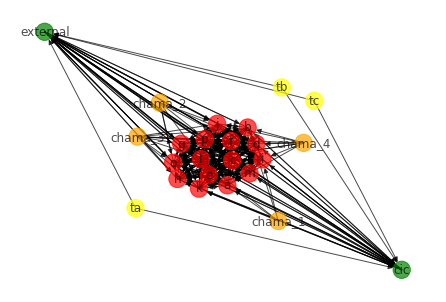

In [5]:

genesis_states = { 
    # initial states of the economy
    'network': create_network(),# networkx market
    'KPIDemand': {},
    'KPISpend': {},
    'KPISpendOverDemand': {},
    'VelocityOfMoney':0,
    'startingBalance': {},
    '30_day_spend': {},
    'withdraw':{},
    'outboundAgents':[],
    'inboundAgents':[],
    'operatorFiatBalance': R0,
    'operatorCICBalance': S0,
    'fundsInProcess': {'timestep':[],'decision':[],'cic':[],'shilling':[]},
    'totalDistributedToAgents':0,
    'totalMinted':0,
    'totalBurned':0
}

In [6]:
# Exogenous 
def startingBalance(params, step, sL, s, _input):
    '''
    Calculate agent starting balance every 30 days
    '''
    y = 'startingBalance'
    network = s['network']

    startingBalance = {}

    timestep = s['timestep']

    division =  timestep % 31  == 0

    if timestep == 1:
        for i in agents:
            startingBalance[i] = network.nodes[i]['tokens']
    elif division == True:
        for i in agents:
            startingBalance[i] = network.nodes[i]['tokens']
    else:
        startingBalance = s['startingBalance']
    x = startingBalance

    return (y, x)

def update_30_day_spend(params, step, sL, s,_input):
    '''
    Aggregate agent spend. Refresh every 30 days.
    '''
    y = '30_day_spend'
    network = s['network']

    timestep = s['timestep']

    division =  timestep % 31  == 0

    if division == True:
        outflowSpend, inflowSpend = iterateEdges(network,'spend')
        spend =  outflowSpend 
    else:
        spendOld = s['30_day_spend']
        outflowSpend, inflowSpend = iterateEdges(network,'spend')
        spend = DictionaryMergeAddition(spendOld,outflowSpend) 

    x = spend
    return (y, x)

def redCrossDrop(params, step, sL, s, _input):
    '''
    Every 30 days, the red cross drips to the grassroots operator node
    '''
    y = 'operatorFiatBalance'
    fiatBalance = s['operatorFiatBalance']
    
    timestep = s['timestep']

    division =  timestep % 30  == 0

    if division == True:
        fiatBalance = fiatBalance + drip
    else:
        pass

    x = fiatBalance
    return (y, x)


def clear_agent_activity(params,step,sL,s,_input):
    '''
    Clear agent activity from the previous timestep
    '''
    y = 'network'
    network = s['network']

    if s['timestep'] > 0:
        outboundAgents = s['outboundAgents']
        inboundAgents = s['inboundAgents']
        
        try:
            for i,j in zip(outboundAgents,inboundAgents):
                network[i][j]['demand'] = 0
        except:
            pass

        # Clear cic % demand edge weights
        try:
            for i,j in zip(outboundAgents,inboundAgents):
                network[i][j]['fractionOfDemandInCIC'] = 0
        except:
            pass


        # Clear utility edge types
        try: 
            for i,j in zip(outboundAgents,inboundAgents):
                network[i][j]['utility'] = 0
        except:
            pass
        
        # Clear cic % spend edge weights
        try:
            for i,j in zip(outboundAgents,inboundAgents):
                network[i][j]['fractionOfActualSpendInCIC'] = 0
        except:
            pass
        # Clear spend edge types
        try: 
            for i,j in zip(outboundAgents,inboundAgents):
                network[i][j]['spend'] = 0
        except:
            pass
    else:
        pass
    x = network
    return (y,x)

In [7]:
# System

# Parameters
agentsMinus = 2
# percentage of balance a user can redeem
redeemPercentage = 0.5

# Behaviors
def choose_agents(params, step, sL, s):
    '''
    Choose agents to interact during the given timestep and create their demand from a uniform distribution. 
    Based on probability, choose utility. 
    '''
    outboundAgents = np.random.choice(mixingAgents,size=len(mixingAgents)-agentsMinus).tolist()
    inboundAgents = np.random.choice(mixingAgents,size=len(mixingAgents)-agentsMinus).tolist()
    stepDemands = np.random.uniform(low=1, high=500, size=len(mixingAgents)-agentsMinus).astype(int)
    

    stepUtilities = np.random.choice(list(UtilityTypesOrdered.keys()),size=len(mixingAgents)-agentsMinus,p=list(utilityTypesProbability.values())).tolist()

    return {'outboundAgents':outboundAgents,'inboundAgents':inboundAgents,'stepDemands':stepDemands,'stepUtilities':stepUtilities}


def spend_allocation(params, step, sL, s):
    '''
    Take mixing agents, demand, and utilities and allocate agent shillings and tokens based on utility and scarcity. 
    '''
    # instantiate network state
    network = s['network']

    spendI = []
    spendJ = []
    spendAmount = []

    # calculate max about of spend available to each agent
    maxSpendShilling = {}
    for i in mixingAgents:
        maxSpendShilling[i] = network.nodes[i]['native_currency']
        
    maxSpendCIC = {}
    for i in mixingAgents:
        maxSpendCIC[i] = network.nodes[i]['tokens']


    for i in mixingAgents: 
        rankOrder = {}
        rankOrderDemand = {}
        for j in network.adj[i]:
            try:
                rankOrder[j] = UtilityTypesOrdered[network.adj[i][j]['utility']]
                rankOrderDemand[j] = network.adj[i][j]['demand']
                rankOrder = dict(OrderedDict(sorted(rankOrder.items(), key=lambda v: v, reverse=False)))
                for k in rankOrder:
                    # if i or j is external, we transact 100% in shilling
                    if i == 'external':
                        amt = spendCalculationExternal(i,j,rankOrderDemand,maxSpendShilling)
                        spendI.append(i)
                        spendJ.append(j)
                        spendAmount.append(amt)
                        maxSpendShilling[i] = maxSpendShilling[i] - amt 
                    elif j == 'external':
                        amt = spendCalculationExternal(i,j,rankOrderDemand,maxSpendShilling)
                        spendI.append(i)
                        spendJ.append(j)
                        spendAmount.append(amt)
                        maxSpendShilling[i] = maxSpendShilling[i] - amt 
                    else:
                        amt = spendCalculation(i,j,rankOrderDemand,maxSpendShilling,maxSpendCIC,fractionOfDemandInCIC)
                        spendI.append(i)
                        spendJ.append(j)
                        spendAmount.append(amt)
                        maxSpendShilling[i] = maxSpendShilling[i] - amt * (1- fractionOfDemandInCIC)
                        maxSpendCIC[i] = maxSpendCIC[i] - (amt * fractionOfDemandInCIC)
            except:
                pass
    return {'spendI':spendI,'spendJ':spendJ,'spendAmount':spendAmount}


def withdraw_calculation(params, step, sL, s):
    ''''''
    # instantiate network state
    network = s['network']

    # Assumptions:
    # * user is only able to withdraw up to 50% of balance, assuming they have spent 50% of balance
    # * Agents will withdraw as much as they can.
    withdraw = {}

    fiftyThreshold = {}

    startingBalance = s['startingBalance']

    spend = s['30_day_spend']
    timestep = s['timestep']

    division =  timestep % 30  == 0

    if division == True:
        for i,j in startingBalance.items():
            fiftyThreshold[i] = j * 0.5
        if s['timestep'] > 7:
            for i,j in fiftyThreshold.items():
                if spend[i] > 0 and fiftyThreshold[i] > 0:
                    if spend[i] * fractionOfActualSpendInCIC >= fiftyThreshold[i]:
                        spent = spend[i]
                        amount = spent * redeemPercentage
                        if network.nodes[i]['tokens'] > amount:
                            withdraw[i] = amount
                        elif  network.nodes[i]['tokens'] < amount:
                            withdraw[i] = network.nodes[i]['tokens']
                    else:
                        pass
                else:
                    pass
        else:
            pass
    else:
        pass


    return {'withdraw':withdraw}

# Mechanisms 
def update_agent_activity(params,step,sL,s,_input):
    '''
    Update the network for interacting agent, their demand, and utility.
    '''
    y = 'network'
    network = s['network']

    outboundAgents = _input['outboundAgents']
    inboundAgents = _input['inboundAgents']
    stepDemands = _input['stepDemands']
    stepUtilities = _input['stepUtilities']
    
    # create demand edge weights
    try:
        for i,j,l in zip(outboundAgents,inboundAgents,stepDemands):
            network[i][j]['demand'] = l
    except:
        pass

    # Create cic % edge weights
    try:
        for i,j in zip(outboundAgents,inboundAgents):
            # if one of the agents is external, we will transact in 100% shilling
            if i == 'external':
                network[i][j]['fractionOfDemandInCIC'] = 1
            elif j == 'external':
                network[i][j]['fractionOfDemandInCIC'] = 1
            else:
                network[i][j]['fractionOfDemandInCIC'] = fractionOfDemandInCIC
    except:
        pass

    # Create utility edge types
    try: 
        for i,j,l in zip(outboundAgents,inboundAgents,stepUtilities):
            network[i][j]['utility'] = l
    except:
        pass

    x = network
    return (y,x)


def update_outboundAgents(params,step,sL,s,_input):
    '''
    Update outBoundAgents state variable
    '''
    y = 'outboundAgents'

    x = _input['outboundAgents']

    return (y,x)

def update_inboundAgents(params,step,sL,s,_input):
    '''
    Update inBoundAgents state variable
    '''
    y = 'inboundAgents'

    x = _input['inboundAgents']
    return (y,x)


def update_node_spend(params, step, sL, s,_input):
    '''
    Update network with actual spend of agents.
    '''
    y = 'network'
    network = s['network']
    
    spendI = _input['spendI']
    spendJ = _input['spendJ']
    spendAmount = _input['spendAmount']

    for i,j,l in zip(spendI,spendJ,spendAmount):   
        network[i][j]['spend'] = l
        if i == 'external':
            network[i][j]['fractionOfActualSpendInCIC'] = 1
        elif j == 'external':
            network[i][j]['fractionOfActualSpendInCIC'] = 1
        else:
            network[i][j]['fractionOfActualSpendInCIC'] = fractionOfActualSpendInCIC

    outflowSpend, inflowSpend = iterateEdges(network,'spend')

    for i, j in inflowSpend.items():
        if i == 'external':
            network.nodes[i]['native_currency'] = network.nodes[i]['native_currency'] +  inflowSpend[i]
        elif j == 'external':
            network.nodes[i]['native_currency'] = network.nodes[i]['native_currency'] +  inflowSpend[i]
        else:
            network.nodes[i]['native_currency'] = network.nodes[i]['native_currency'] +  inflowSpend[i] * (1- fractionOfDemandInCIC)
            network.nodes[i]['tokens'] = network.nodes[i]['tokens'] + (inflowSpend[i] * fractionOfDemandInCIC)
        
    for i, j in outflowSpend.items():
        if i == 'external':
            network.nodes[i]['native_currency'] = network.nodes[i]['native_currency'] - outflowSpend[i]
        elif j == 'external':
            network.nodes[i]['native_currency'] = network.nodes[i]['native_currency'] - outflowSpend[i]
        else:
            network.nodes[i]['native_currency'] = network.nodes[i]['native_currency'] - outflowSpend[i]* (1- fractionOfDemandInCIC)
            network.nodes[i]['tokens'] = network.nodes[i]['tokens'] - (outflowSpend[i] * fractionOfDemandInCIC)

    # Store the net of the inflow and outflow per step
    network.nodes['external']['delta_native_currency'] = sum(inflowSpend.values()) - sum(outflowSpend.values())

    x = network
    return (y,x)


def update_withdraw(params, step, sL, s,_input):
    '''
    Update flow sstate variable with the aggregated amount of shillings withdrawn
    '''
    y = 'withdraw'
    x = s['withdraw']
    if _input['withdraw']:
        x = _input['withdraw']
    else:
        x = 0

    return (y,x)

def update_network_withraw(params, step, sL, s,_input):
    '''
    Update network for agents withdrawing 
    '''
    y = 'network'
    network = s['network']
    withdraw = _input['withdraw']

    if withdraw:
        for i,j in withdraw.items():
            # update agent nodes
            network.nodes[i]['tokens'] = network.nodes[i]['tokens'] - j
            network.nodes[i]['native_currency'] = network.nodes[i]['native_currency'] + (j * leverage)

        withdrawnCICSum = []
        for i,j in withdraw.items():
            withdrawnCICSum.append(j)
        
        # update cic node
        network.nodes['cic']['native_currency'] = network.nodes[i]['native_currency'] - (sum(withdrawnCICSum) * leverage)
        network.nodes['cic']['tokens'] = network.nodes[i]['tokens'] + (sum(withdrawnCICSum) * leverage)

    else:
        pass
    x = network
    return (y,x)



In [8]:
# Operating Entity

# Parameters
FrequencyOfAllocation = 45 # every two weeks
idealFiat = 5000
idealCIC = 200000
varianceCIC = 50000
varianceFiat = 1000
unadjustedPerAgent = 50




agentAllocation = {'a':[1,1],'b':[1,1],'c':[1,1], # agent:[centrality,allocationValue]
                   'd':[1,1],'e':[1,1],'f':[1,1],
                   'g':[1,1],'h':[1,1],'i':[1,1],
                   'j':[1,1],'k':[1,1],'l':[1,1],
                   'm':[1,1],'o':[1,1],'p':[1,1]}

# Behaviors
def disbursement_to_agents(params, step, sL, s):
    '''
    Distribute every FrequencyOfAllocation days to agents based off of centrality allocation metric
    '''
    fiatBalance = s['operatorFiatBalance']
    cicBalance = s['operatorCICBalance']
    timestep = s['timestep']

    division =  timestep % FrequencyOfAllocation  == 0

    if division == True:
        agentDistribution ={} # agent: amount distributed
        for i,j in agentAllocation.items():
            agentDistribution[i] = unadjustedPerAgent * agentAllocation[i][1]
        distribute = 'Yes'
        
    else:
        agentDistribution = 0
        distribute = 'No'


    return {'distribute':distribute,'amount':agentDistribution}


def inventory_controller(params, step, sL, s):
    '''
    Monetary policy hysteresis conservation allocation between fiat and cic reserves.
    
    '''
    fiatBalance = s['operatorFiatBalance']
    cicBalance = s['operatorCICBalance']
    timestep = s['timestep']
    fundsInProcess = s['fundsInProcess']


    updatedCIC = cicBalance
    updatedFiat = fiatBalance

    #decision,amt = mint_burn_logic_control(idealCIC,updatedCIC,variance,updatedFiat)
    decision,amt = mint_burn_logic_control(idealCIC,updatedCIC,varianceCIC,updatedFiat,varianceFiat,idealFiat)

    if decision == 'burn':
        try:
            deltaR, realized_price = withdraw(amt,updatedFiat,updatedCIC, V0, kappa)
            # update state
            # fiatBalance = fiatBalance - deltaR
            # cicBalance = cicBalance - amt
            fiatChange = abs(deltaR)
            cicChange = amt

        except:
            print('Not enough to burn')

            fiatChange = 0
            cicChange = 0
        
    elif decision == 'mint':
        try:
            deltaS, realized_price = mint(amt,updatedFiat,updatedCIC, V0, kappa)
            # update state
            # fiatBalance = fiatBalance + amt
            # cicBalance = cicBalance + deltaS
            fiatChange = amt
            cicChange = abs(deltaS)

        except:
            print('Not enough to mint')
            fiatChange = 0
            cicChange = 0

    else:
        fiatChange = 0
        cicChange = 0
        decision = 'none'
        pass

    if decision == 'mint':
        fundsInProcess['timestep'].append(timestep + process_lag)
        fundsInProcess['decision'].append(decision)
        fundsInProcess['cic'].append(fiatChange)
        fundsInProcess['shilling'].append(cicChange)
    elif decision == 'burn':
        fundsInProcess['timestep'].append(timestep +process_lag)
        fundsInProcess['decision'].append(decision)
        fundsInProcess['cic'].append(fiatChange)
        fundsInProcess['shilling'].append(cicChange)
    else:
        pass
    
    return {'decision':decision,'fiatChange':fiatChange,'cicChange':cicChange,'fundsInProcess':fundsInProcess}



# Mechanisms 
def update_agent_tokens(params,step,sL,s,_input):
    '''
    '''
    y = 'network'
    network = s['network']

    distribute = _input['distribute']
    amount = _input['amount']

    if distribute == 'Yes':
        for i in agents:
            network.nodes[i]['tokens'] = network.nodes[i]['tokens'] + amount[i]
    else:
        pass

    return (y,network)

def update_operator_FromDisbursements(params,step,sL,s,_input):
    '''
    '''
    y = 'operatorCICBalance'
    x = s['operatorCICBalance']
    timestep = s['timestep']
    
    distribute = _input['distribute']
    amount = _input['amount'] 

    if distribute == 'Yes':
        totalDistribution = []
        for i,j in amount.items():
            totalDistribution.append(j)
        
        totalDistribution = sum(totalDistribution)
        x = x - totalDistribution

    else:
        pass

    return (y,x)

def update_totalDistributedToAgents(params,step,sL,s,_input):
    '''
    '''
    y = 'totalDistributedToAgents'
    x = s['totalDistributedToAgents']
    timestep = s['timestep']
    
    distribute = _input['distribute']
    amount = _input['amount'] 

    if distribute == 'Yes':
        totalDistribution = []
        for i,j in amount.items():
            totalDistribution.append(j)
        
        totalDistribution = sum(totalDistribution)
        x = x + totalDistribution
    else:
        pass

    return (y,x)

def update_operator_fiatBalance(params,step,sL,s,_input):
    '''
    '''
    y = 'operatorFiatBalance'
    x = s['operatorFiatBalance']
    fundsInProcess = s['fundsInProcess']
    timestep = s['timestep']
    if _input['fiatChange']:
        try:
            if fundsInProcess['timestep'][0] == timestep + 1:
                if fundsInProcess['decision'][0] == 'mint':
                    x = x - abs(fundsInProcess['shilling'][0])
                elif fundsInProcess['decision'][0] == 'burn':
                    x = x + abs(fundsInProcess['shilling'][0])
            else:
                pass
        except:
            pass
    else:
        pass


    return (y,x)

def update_operator_cicBalance(params,step,sL,s,_input):
    '''
    '''
    y = 'operatorCICBalance'
    x = s['operatorCICBalance']
    fundsInProcess = s['fundsInProcess']
    timestep = s['timestep']

    if _input['cicChange']:
        try:
            if fundsInProcess['timestep'][0] == timestep + 1:
                if fundsInProcess['decision'][0] == 'mint':
                    x = x + abs(fundsInProcess['cic'][0])
                elif fundsInProcess['decision'][0] == 'burn':
                    x = x - abs(fundsInProcess['cic'][0])
            else:
                pass
        except:
            pass
    else:
        pass

    return (y,x)

def update_totalMinted(params,step,sL,s,_input):
    '''
    '''
    y = 'totalMinted'
    x = s['totalMinted']
    timestep = s['timestep']
    try:
        if _input['fundsInProcess']['decision'][0] == 'mint':
            x = x + abs(_input['fundsInProcess']['cic'][0])
        elif _input['fundsInProcess']['decision'][0] == 'burn':
            pass
    except:
        pass


    return (y,x)

def update_totalBurned(params,step,sL,s,_input):
    '''
    '''
    y = 'totalBurned'
    x = s['totalBurned']
    timestep = s['timestep']
    try:
        if _input['fundsInProcess']['decision'][0] == 'burn':
            x = x + abs(_input['fundsInProcess']['cic'][0])
        elif _input['fundsInProcess']['decision'][0] == 'mint':
            pass
    except:
        pass

    return (y,x)

def update_fundsInProcess(params,step,sL,s,_input):
    '''
    '''
    y = 'fundsInProcess'
    x = _input['fundsInProcess']
    timestep = s['timestep']

    if _input['fundsInProcess']:
        try:
            if x['timestep'][0] == timestep:
                del x['timestep'][0]
                del x['decision'][0]
                del x['cic'][0]
                del x['shilling'][0]
            else:
                pass
        except:
            pass
    else:
        pass

    return (y,x)

In [9]:
# KPI

# Behaviors
def kpis(params, step, sL, s):
    ''''''
    # instantiate network state
    network = s['network']

    KPIDemand = {}
    KPISpend = {}
    KPISpendOverDemand = {}
    for i in mixingAgents:
        demand = []
        for j in network.adj[i]:
            try:
                demand.append(network.adj[i][j]['demand'])
            except:
                pass

        spend = []
        for j in network.adj[i]:
            try:
                spend.append(network.adj[i][j]['spend'])
            except:
                pass

        sumDemand = sum(demand)
        sumSpend = sum(spend)
        try:
            spendOverDemand = sumSpend/sumDemand
        except:
            spendOverDemand = 0

        KPIDemand[i] = sumDemand
        KPISpend[i] = sumSpend
        KPISpendOverDemand[i] = spendOverDemand

    #print(nx.katz_centrality_numpy(G=network,weight='spend'))
    return {'KPIDemand':KPIDemand,'KPISpend':KPISpend,'KPISpendOverDemand':KPISpendOverDemand}

def velocity_of_money(params, step, sL, s):
    ''''''
    # instantiate network state
    network = s['network']

    KPISpend = s['KPISpend']

    # TODO: Moving average for state variable
    T = []
    for i,j in KPISpend.items():
        T.append(j)
        
    T = sum(T)
    
    # TODO Moving average for state variable 
    M = []
    for i in agents:
        M.append(network.nodes[i]['tokens'] + network.nodes[i]['native_currency'])
        
    M = sum(M)
    
    V_t = (priceLevel *T)/M

    return {'V_t':V_t,'T':T,'M':M}


# Mechanisms
def update_KPIDemand(params, step, sL, s,_input):
    y = 'KPIDemand'
    x = _input['KPIDemand']
    return (y,x)

def update_KPISpend(params, step, sL, s,_input):
    y = 'KPISpend'
    x = _input['KPISpend']
    return (y,x)

def update_KPISpendOverDemand(params, step, sL, s,_input):
    y = 'KPISpendOverDemand'
    x = _input['KPISpendOverDemand']
    return (y,x)


def update_velocity_of_money(params, step, sL, s,_input):
    y = 'VelocityOfMoney'
    x = _input['V_t']
    return (y,x)


In [10]:
# partial state update block
partial_state_update_block = {
    # Exogenous
    'Exogenous': {
        'policies': {
        },
        'variables': {
            'startingBalance': startingBalance,
            'operatorFiatBalance': redCrossDrop,
            '30_day_spend': update_30_day_spend,
            'network':clear_agent_activity
        }
    },
    # Users
    'Behaviors': {
        'policies': {
            'action': choose_agents
        },
        'variables': {
        'network': update_agent_activity,
        'outboundAgents': update_outboundAgents,
        'inboundAgents':update_inboundAgents
        }
    },
    'Spend allocation': {
        'policies': {
            'action': spend_allocation
        },
        'variables': {
        'network': update_node_spend
        }
    },
    'Withdraw behavior': {
        'policies': {
            'action': withdraw_calculation
        },
        'variables': {
        'withdraw': update_withdraw,
        'network':update_network_withraw
        }
    },
    # Operator
    'Operator Disburse to Agents': {
        'policies': {
            'action': disbursement_to_agents
        },
        'variables': {
        'network':update_agent_tokens,
        'operatorCICBalance':update_operator_FromDisbursements,
        'totalDistributedToAgents':update_totalDistributedToAgents
        }
    },
    'Operator Inventory Control': {
        'policies': {
            'action': inventory_controller
        },
        'variables': {
        'operatorFiatBalance':update_operator_fiatBalance,
        'operatorCICBalance':update_operator_cicBalance, 
        'totalMinted': update_totalMinted,
        'totalBurned':update_totalBurned,
        'fundsInProcess':update_fundsInProcess
        }
    },
    # KPIs
    'KPIs': {
        'policies': {
            'action':kpis
        },
        'variables':{
            'KPIDemand': update_KPIDemand,
            'KPISpend': update_KPISpend,
            'KPISpendOverDemand': update_KPISpendOverDemand        
        }
    },
    'Velocity': {
        'policies': {
            'action':velocity_of_money
        },
        'variables':{

            'VelocityOfMoney': update_velocity_of_money
        }
    }
}


In [11]:
# config
params: Dict[str, List[int]] = {
    'month': [0,12,36,50,100]
}


sim_config = config_sim({
    'N': 5,
    'T': range(100), #day 
#     'M': #params,
})

seeds = {
    'p': np.random.RandomState(26042019),
}
env_processes = {}


append_configs(
    sim_configs=sim_config,
    initial_state=genesis_states,
    seeds=seeds,
    env_processes=env_processes,
    partial_state_update_blocks=partial_state_update_block
)

[{'N': 5, 'T': range(0, 100), 'M': [{}]}]


# Run cadCAD model

In [14]:
exec_mode = ExecutionMode()

In [15]:
single_proc_ctx = ExecutionContext(context=exec_mode.single_proc)
run1 = Executor(exec_context=single_proc_ctx, configs=[configs[0]])
run1_raw_result, raw_tensor_field = run1.execute()
df = pd.DataFrame(run1_raw_result)


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: single_proc: [<cadCAD.configuration.Configuration object at 0x7f8787b0a690>]
Configurations: [<cadCAD.configuration.Configuration object at 0x7f8787b0a690>]


/home/aclarkdata/anaconda3/lib/python3.7/site-packages/cadCAD/utils/__init__.py:113: FutureWarning: The use of a dictionary to describe Partial State Update Blocks will be deprecated. Use a list instead.
  FutureWarning)


In [16]:
# Set subsetep to last
df = df[df['substep'] == df['substep'].max()]

In [17]:
df.head()

,network,KPIDemand,KPISpend,KPISpendOverDemand,VelocityOfMoney,startingBalance,30_day_spend,withdraw,outboundAgents,inboundAgents,operatorFiatBalance,operatorCICBalance,fundsInProcess,totalDistributedToAgents,totalMinted,totalBurned,run,substep,timestep
8,"(a, b, c, d, e, f, g, h, i, j, k, l, m, o, p, ...","{'a': 0, 'b': 0, 'c': 338, 'd': 398, 'e': 166,...","{'a': 0, 'b': 0, 'c': 57, 'd': 398, 'e': 166, ...","{'a': 0, 'b': 0, 'c': 0.16863905325443787, 'd'...",21.78,"{'a': 400, 'b': 400, 'c': 400, 'd': 400, 'e': ...",{},0,"[e, l, g, h, d, f, c, l, f, o, g, l, external, f]","[a, h, m, l, m, l, d, f, a, b, h, d, i, d]",4500,200000.00,"{'timestep': [], 'decision': [], 'cic': [], 's...",0,0,0,1,8,1
16,"(a, b, c, d, e, f, g, h, i, j, k, l, m, o, p, ...","{'a': 83, 'b': 0, 'c': 0, 'd': 664, 'e': 0, 'f...","{'a': 83, 'b': 0, 'c': 0, 'd': 289.125, 'e': 0...","{'a': 1.0, 'b': 0, 'c': 0, 'd': 0.435429216867...",11.87,"{'a': 583.0, 'b': 578.0, 'c': 371.5, 'd': 401....","{'c': 57, 'd': 398, 'e': 166, 'f': 254.5625, '...",0,"[h, f, a, d, d, i, l, h, m, d, l, m, h, i]","[e, external, o, a, l, external, o, k, m, m, d...",4500,200000.00,"{'timestep': [], 'decision': [], 'cic': [], 's...",0,0,0,1,8,2
24,"(a, b, c, d, e, f, g, h, i, j, k, l, m, o, p, ...","{'a': 0, 'b': 195, 'c': 0, 'd': 258, 'e': 317,...","{'a': 0, 'b': 195, 'c': 0, 'd': 60.1875, 'e': ...","{'a': 0, 'b': 1.0, 'c': 0, 'd': 0.233284883720...",21.00,"{'a': 583.0, 'b': 578.0, 'c': 371.5, 'd': 401....","{'a': 83, 'i': 214, 'c': 57, 'd': 687.125, 'e'...",0,"[j, g, j, k, external, k, k, k, d, b, m, k, e,...","[m, c, p, d, l, external, o, o, a, m, p, b, c, e]",4500,200000.00,"{'timestep': [], 'decision': [], 'cic': [], 's...",0,0,0,1,8,3
32,"(a, b, c, d, e, f, g, h, i, j, k, l, m, o, p, ...","{'a': 8, 'b': 0, 'c': 140, 'd': 0, 'e': 623, '...","{'a': 8, 'b': 0, 'c': 140, 'd': 0, 'e': 227.87...","{'a': 1.0, 'b': 0, 'c': 1.0, 'd': 0, 'e': 0.36...",16.09,"{'a': 583.0, 'b': 578.0, 'c': 371.5, 'd': 401....","{'b': 195, 'j': 328, 'k': 198.0625, 'm': 415, ...",0,"[c, a, k, e, e, f, m, p, j, i, i, k, m, e]","[p, l, j, i, g, p, f, b, k, a, f, a, p, e]",4500,200000.00,"{'timestep': [], 'decision': [], 'cic': [], 's...",0,0,0,1,8,4
40,"(a, b, c, d, e, f, g, h, i, j, k, l, m, o, p, ...","{'a': 134, 'b': 0, 'c': 202, 'd': 0, 'e': 0, '...","{'a': 134, 'b': 0, 'c': 38.9375, 'd': 0, 'e': ...","{'a': 1.0, 'b': 0, 'c': 0.19275990099009901, '...",8.44,"{'a': 583.0, 'b': 578.0, 'c': 371.5, 'd': 401....","{'p': 92, 'b': 195, 'j': 669, 'k': 231.0625, '...",0,"[m, k, j, a, p, c, external, p, o, o, l, m, c,...","[c, i, e, h, b, a, external, f, h, f, b, l, a, m]",4500,200000.00,"{'timestep': [], 'decision': [], 'cic': [], 's...",0,0,0,1,8,5


In [18]:
df.reset_index(inplace=True)
del df['index']

In [19]:
df['agents'] = df.network.apply(lambda g: np.array([get_nodes_by_type(g,'Agent')][0]))

In [20]:
df['agent_tokens'] = df.network.apply(lambda g: np.array([g.nodes[j]['tokens'] for j in get_nodes_by_type(g,'Agent')]))

In [21]:
df['agent_native_currency'] = df.network.apply(lambda g: np.array([g.nodes[j]['native_currency'] for j in get_nodes_by_type(g,'Agent')]))

In [22]:
df.tail()

,network,KPIDemand,KPISpend,KPISpendOverDemand,VelocityOfMoney,startingBalance,30_day_spend,withdraw,outboundAgents,inboundAgents,...,fundsInProcess,totalDistributedToAgents,totalMinted,totalBurned,run,substep,timestep,agents,agent_tokens,agent_native_currency
495,"(a, b, c, d, e, f, g, h, i, j, k, l, m, o, p, ...","{'a': 362, 'b': 353, 'c': 0, 'd': 0, 'e': 0, '...","{'a': 362, 'b': 353, 'c': 0, 'd': 0, 'e': 0, '...","{'a': 1.0, 'b': 1.0, 'c': 0, 'd': 0, 'e': 0, '...",14.32,"{'a': 3549.1844038994227, 'b': -759.6566540305...","{'a': 407, 'b': 517.5246942932349, 'c': 359, '...",0,"[external, external, o, a, a, b, h, j, m, o, m...","[l, e, d, j, p, m, external, m, g, h, k, f, i,...",...,"{'timestep': [], 'decision': [], 'cic': [], 's...",1500,0,0,5,8,96,"[a, b, c, d, e, f, g, h, i, j, k, l, m, o, p]","[3843.699663730596, 1181.2082080925675, 858.53...","[4405.7172278645585, 2458.3895564163895, 1173...."
496,"(a, b, c, d, e, f, g, h, i, j, k, l, m, o, p, ...","{'a': 303, 'b': 0, 'c': 0, 'd': 164, 'e': 0, '...","{'a': 303, 'b': 0, 'c': 0, 'd': 164, 'e': 0, '...","{'a': 1.0, 'b': 0, 'c': 0, 'd': 1.0, 'e': 0, '...",18.23,"{'a': 3549.1844038994227, 'b': -759.6566540305...","{'a': 769, 'b': 870.5246942932349, 'c': 359, '...",0,"[o, i, j, d, a, d, o, o, g, g, p, j, j, o]","[m, b, o, i, d, a, g, external, k, k, l, h, k, l]",...,"{'timestep': [], 'decision': [], 'cic': [], 's...",1500,0,0,5,8,97,"[a, b, c, d, e, f, g, h, i, j, k, l, m, o, p]","[3736.199663730596, 1375.573975395193, 858.534...","[4298.2172278645585, 2652.755323719015, 1173.5..."
497,"(a, b, c, d, e, f, g, h, i, j, k, l, m, o, p, ...","{'a': 521, 'b': 537, 'c': 0, 'd': 0, 'e': 0, '...","{'a': 521, 'b': 537, 'c': 0, 'd': 0, 'e': 0, '...","{'a': 1.0, 'b': 1.0, 'c': 0, 'd': 0, 'e': 0, '...",15.31,"{'a': 3549.1844038994227, 'b': -759.6566540305...","{'a': 1072, 'b': 870.5246942932349, 'c': 359, ...",0,"[p, m, a, o, g, h, m, l, l, l, a, b, l, b]","[f, a, i, g, a, l, o, h, e, c, o, p, g, k]",...,"{'timestep': [], 'decision': [], 'cic': [], 's...",1500,0,0,5,8,98,"[a, b, c, d, e, f, g, h, i, j, k, l, m, o, p]","[4018.122226032855, 1107.073975395193, 970.822...","[4580.139790166818, 2384.255323719015, 1285.80..."
498,"(a, b, c, d, e, f, g, h, i, j, k, l, m, o, p, ...","{'a': 177, 'b': 322, 'c': 0, 'd': 109, 'e': 0,...","{'a': 177, 'b': 322, 'c': 0, 'd': 109, 'e': 0,...","{'a': 1.0, 'b': 1.0, 'c': 0, 'd': 1.0, 'e': 0,...",28.10,"{'a': 3549.1844038994227, 'b': -759.6566540305...","{'a': 1593, 'b': 1407.524694293235, 'c': 359, ...",0,"[l, i, d, p, d, j, o, a, f, b, m, f, g, p]","[k, p, a, b, o, external, l, i, o, e, b, c, c, m]",...,"{'timestep': [], 'decision': [], 'cic': [], 's...",1500,0,0,5,8,99,"[a, b, c, d, e, f, g, h, i, j, k, l, m, o, p]","[3971.622226032855, 1230.0205571398026, 2492.6...","[4533.639790166818, 2507.201905463625, 2807.62..."
499,"(a, b, c, d, e, f, g, h, i, j, k, l, m, o, p, ...","{'a': 0, 'b': 118, 'c': 0, 'd': 503, 'e': 0, '...","{'a': 0, 'b': 118, 'c': 0, 'd': 503, 'e': 0, '...","{'a': 0, 'b': 1.0, 'c': 0, 'd': 1.0, 'e': 0, '...",16.48,"{'a': 3549.1844038994227, 'b': -759.6566540305...","{'a': 1770, 'b': 1729.524694293235, 'c': 359, ...",0,"[f, h, l, p, d, k, f, b, d, h, m, g, k, f]","[o, m, e, external, a, p, k, k, m, g, o, f, g, k]",...,"{'timestep': [], 'decision': [], 'cic': [], 's...",1500,0,0,5,8,100,"[a, b, c, d, e, f, g, h, i, j, k, l, m, o, p]","[4030.622226032855, 1171.0205571398026, 2492.6...","[4592.639790166818, 2448.201905463625, 2807.62..."


In [23]:
# Create dataframe variables   
tokens = []
for i in df.index:
     tokens.append(sum(df['agent_tokens'][i]))
        
df['AggregatedAgentCICHolding'] = tokens  

currency = []
for i in df.index:
     currency.append(sum(df['agent_native_currency'][i]))
        
df['AggregatedAgentCurrencyHolding'] = currency  

AggregatedSpend = []
for i in df.index:
     AggregatedSpend.append(sum(df['KPISpend'][i].values()))

df['AggregatedAgentSpend'] = AggregatedSpend   

AggregatedDemand = []
for i in df.index:
     AggregatedDemand.append(sum(df['KPIDemand'][i].values()))
        
df['AggregatedAgentDemand'] = AggregatedDemand  


AggregatedKPISpendOverDemand = []
for i in df.index:
     AggregatedKPISpendOverDemand.append(sum(df['KPISpendOverDemand'][i].values()))
        
df['AggregatedKPISpendOverDemand'] = AggregatedKPISpendOverDemand  


AggregatedGapOfDemandMinusSpend = []
for i in df.index:
     AggregatedGapOfDemandMinusSpend.append(sum(df['KPIDemand'][i].values())- sum(df['KPISpend'][i].values()))
        
df['AggregatedGapOfDemandMinusSpend'] = AggregatedGapOfDemandMinusSpend  

In [24]:
df['KPISpend'][1]['external']

0

In [25]:
subset = df[['timestep', 'VelocityOfMoney', 'operatorFiatBalance',
       'operatorCICBalance', 'totalDistributedToAgents', 'totalMinted',
       'totalBurned', 'run', 'substep', 'AggregatedAgentCICHolding',
       'AggregatedAgentCurrencyHolding', 'AggregatedAgentSpend',
       'AggregatedAgentDemand', 'AggregatedKPISpendOverDemand',
       'AggregatedGapOfDemandMinusSpend']]

In [26]:
mean_df,median_df,std_df,min_df = aggregate_runs(subset,'timestep')

In [27]:
mean_df.tail()

,timestep,VelocityOfMoney,operatorFiatBalance,operatorCICBalance,totalDistributedToAgents,totalMinted,totalBurned,run,substep,AggregatedAgentCICHolding,AggregatedAgentCurrencyHolding,AggregatedAgentSpend,AggregatedAgentDemand,AggregatedKPISpendOverDemand,AggregatedGapOfDemandMinusSpend
95,96,15.73,16500.00,198500.00,1500.00,0.00,0.00,3.00,8.00,-1137.20,19352.37,2937.30,2482.00,13.00,-455.30
96,97,17.29,16500.00,198500.00,1500.00,0.00,0.00,3.00,8.00,-1190.60,19298.97,3159.83,2265.00,66.37,-894.83
97,98,19.40,16500.00,198500.00,1500.00,0.00,0.00,3.00,8.00,-1203.81,19285.75,3279.11,2934.00,10.01,-345.11
98,99,14.27,16500.00,198500.00,1500.00,0.00,0.00,3.00,8.00,-1243.41,19246.15,2684.56,1840.00,19.34,-844.56
99,100,14.77,16500.00,198500.00,1500.00,0.00,0.00,3.00,8.00,-1265.61,19223.96,2701.91,2093.00,8.65,-608.91


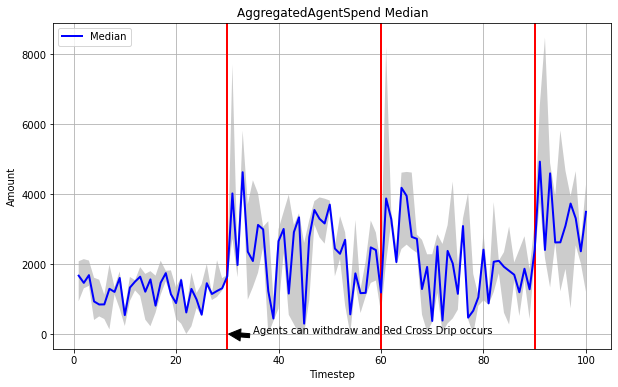

In [28]:
# plot of agent activity per timestep
plot_median_with_quantiles_annotation(subset,'timestep','timestep','AggregatedAgentSpend')

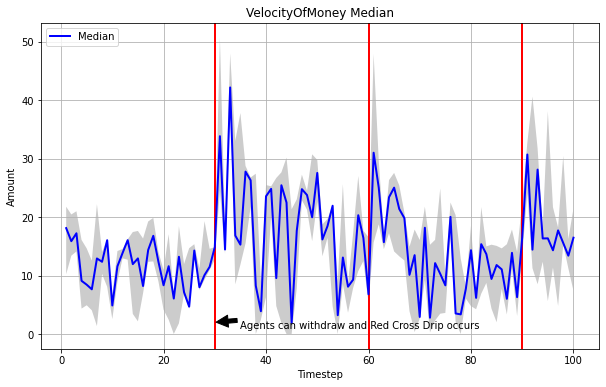

In [29]:
plot_median_with_quantiles_annotation(subset,'timestep','timestep','VelocityOfMoney')

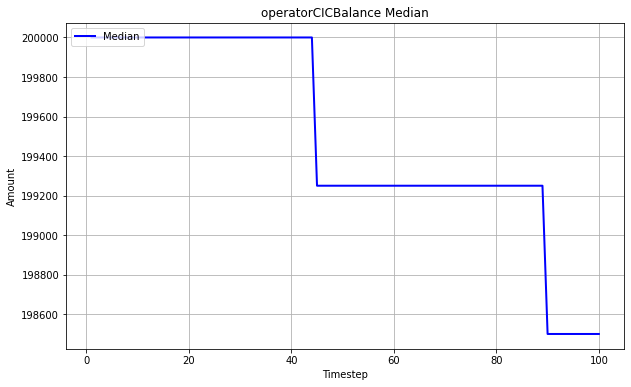

In [30]:
plot_median_with_quantiles(subset,'timestep','timestep','operatorCICBalance')

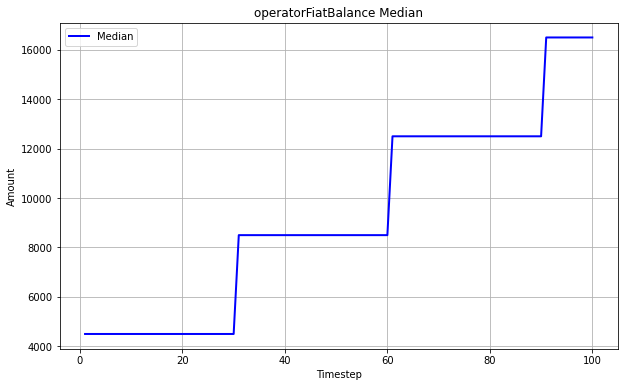

In [31]:
plot_median_with_quantiles(subset,'timestep','timestep','operatorFiatBalance')

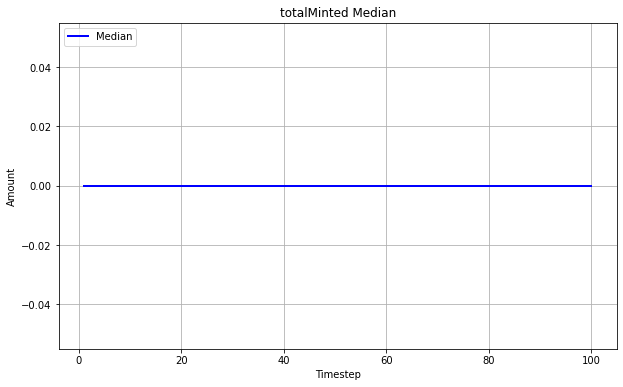

In [32]:
plot_median_with_quantiles(subset,'timestep','timestep','totalMinted')

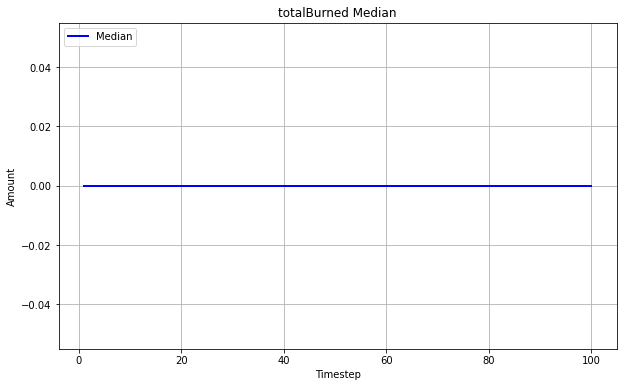

In [33]:
plot_median_with_quantiles(subset,'timestep','timestep','totalBurned')

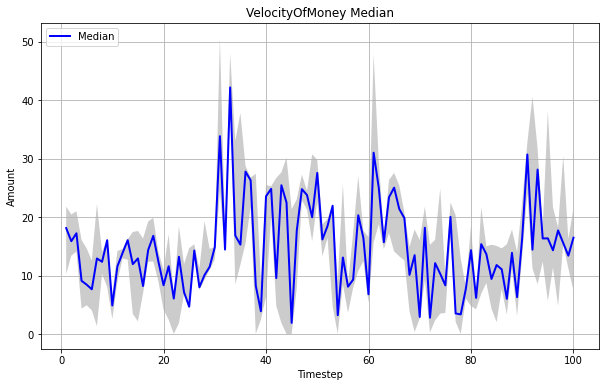

In [34]:
plot_median_with_quantiles(subset,'timestep','timestep','VelocityOfMoney')

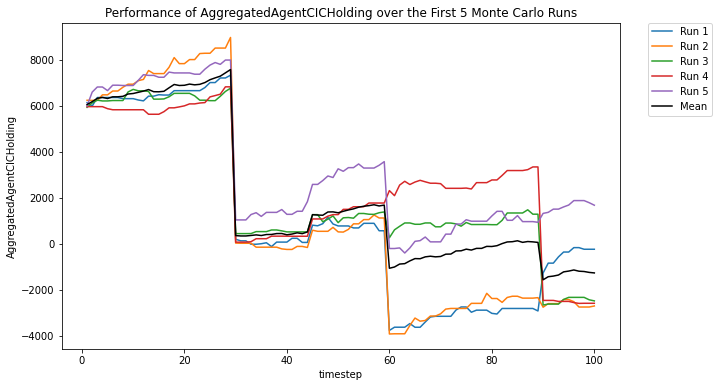

In [35]:
first_five_plot(subset,'timestep','timestep','AggregatedAgentCICHolding',5)

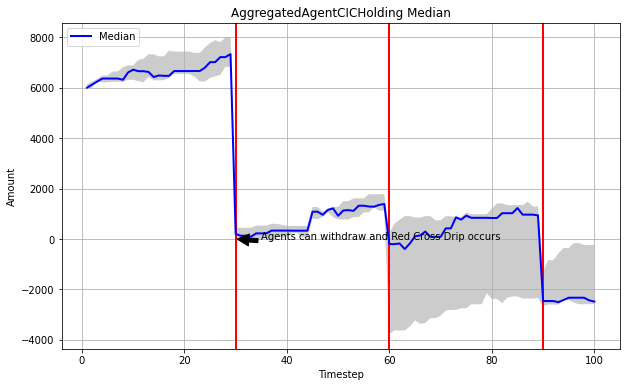

In [36]:
plot_median_with_quantiles_annotation(subset,'timestep','timestep','AggregatedAgentCICHolding')

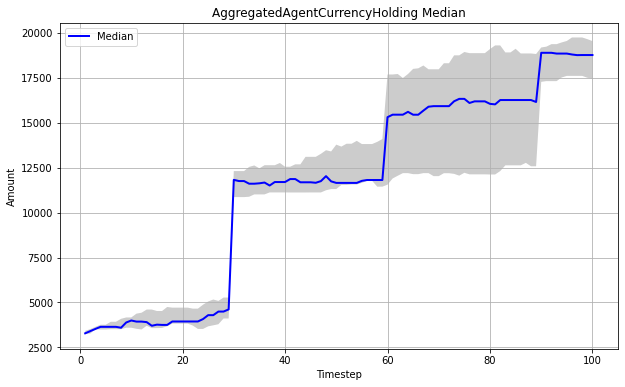

In [37]:
plot_median_with_quantiles(subset,'timestep','timestep','AggregatedAgentCurrencyHolding')

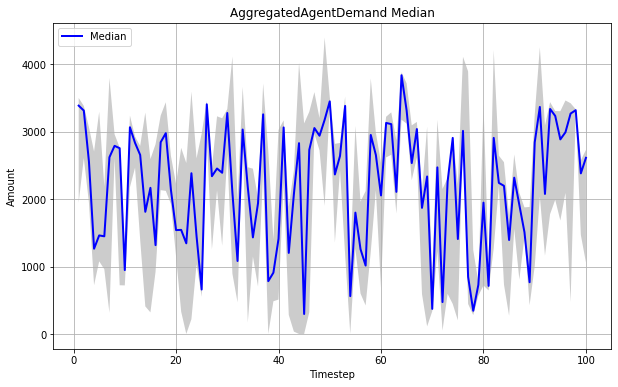

In [38]:
plot_median_with_quantiles(subset,'timestep','timestep','AggregatedAgentDemand')